In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plot_dir = './plots/'

# 20180928

# Read in Beacon Data 

In [3]:
df = sd.get_df(sd.dir_path + sd.csv_filenames[1])
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulation

In [4]:
tc = test_case.TestCase()

In [5]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

Ca, Cw = 3, 0.1
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results1 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

Ca, Cw = 0.1, 5
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results2 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

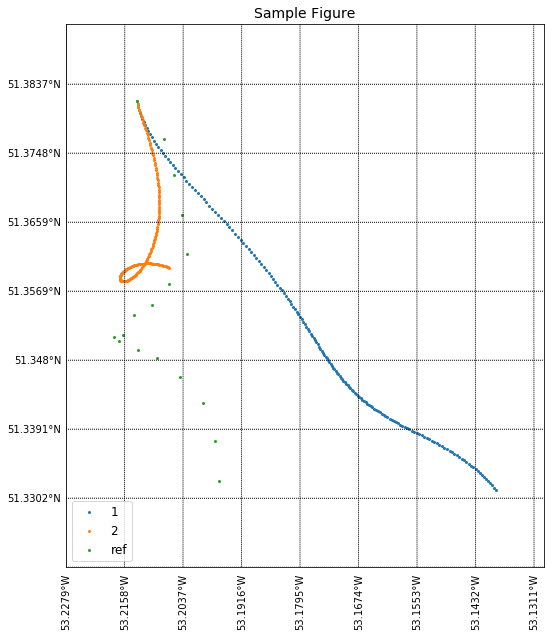

In [6]:
fig, ax = plot.plot_track([results1['latitude'].values, results1['longitude'].values],
                [results2['latitude'].values, results2['longitude'].values],
                [tc.ref_lats.values, tc.ref_lons.values], 
                s=4, labels = ['1', '2', 'ref'], title='Sample Figure'
)                

# Optimization

In [7]:
keys = ['Ca', 'Cw']
x0 = [1, 1]
bounds = [[1, 2], [1,15]]
reference_vectors = [tc.ref_lats, tc.ref_lons]

sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

In [8]:
optimization_result

      fun: 0.00905690813519615
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.63316753e-04, 5.16774123e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 9
   status: 0
  success: True
        x: array([ 1.        , 12.57859484])

## Simulation with Optimization Result

In [9]:
Ca, Cw = optimization_result.x

run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(**run_sim_kwargs)

No handles with labels found to put in legend.


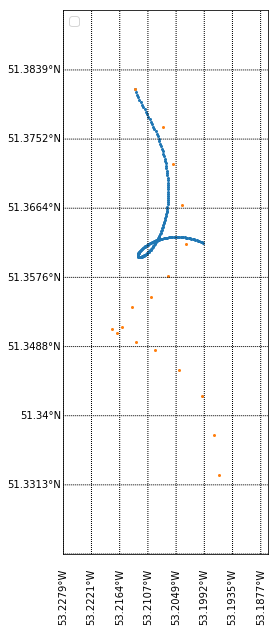

In [11]:
fig, ax = plot.plot_track([results['latitude'].values, results['longitude'].values],
                          [tc.ref_lats.values, tc.ref_lons.values], pads=[0.01]*4, s=4)

# Surface Optimization

In [12]:
Ca_num = 3
Cw_num = 3
Ca_lower_bound = 1; Ca_upper_bound = 5
Cw_lower_bound = 5; Cw_upper_bound = 16

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':
    
    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [13]:
mse_matrix = np.zeros((Ca_num, Cw_num))
keys = ['Ca', 'Cw']
reference_vectors = [tc.ref_lats, tc.ref_lons]

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

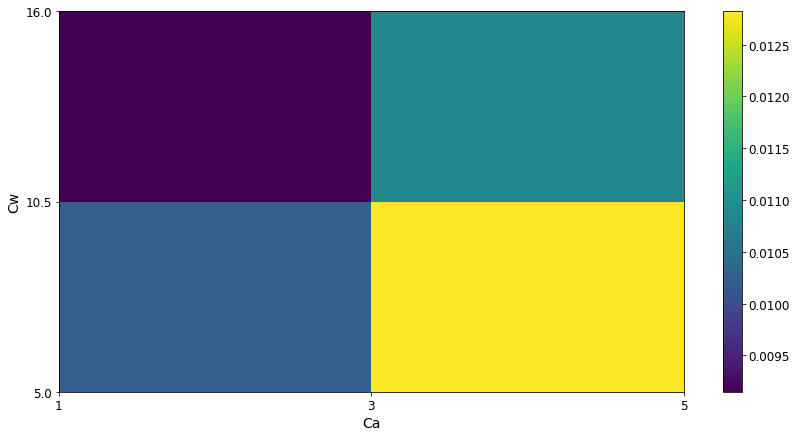

In [14]:
fig = plt.figure(figsize=(14,7))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix)#, vmin=0.02525, vmax=0.02675)

plt.xticks(Ca_vec)#, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.colorbar()

plt.show()

# 20181011

# Ekman

In [15]:
label = 'ekman'

# No Ekman
ekman = False
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='no_ekman', **kwargs)

# Ekman to depth of 100 m
ekman = True
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='ekman_100', **kwargs)

# Ekman to depth of 1000 m
ekman = True
depth_vec = np.arange(0, -1100, -100)
kwargs = {'ekman': ekman, 'depth_vec': depth_vec}
xds = sim.run_simulation(store_results_as='ekman_1000', **kwargs)

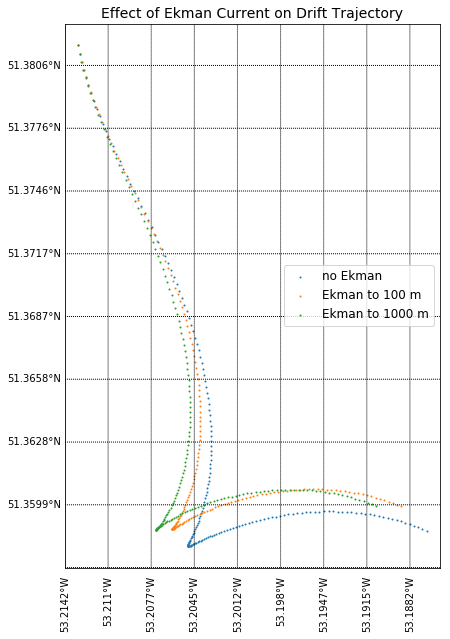

In [16]:
title = 'Effect of Ekman Current on Drift Trajectory'
pads = [0.001] * 4
labels = ['no Ekman', 'Ekman to 100 m', 'Ekman to 1000 m']
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = sim.plot_track(['no_ekman', 'ekman_100', 'ekman_1000'], **kwargs)
fig.savefig(plot_dir + label + '.png')

# Testing Drift Model with Constant Metocean Fields

In [17]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

## Default

In [18]:
label = 'default'
xds = sim.run_simulation(store_results_as=label)

In [19]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

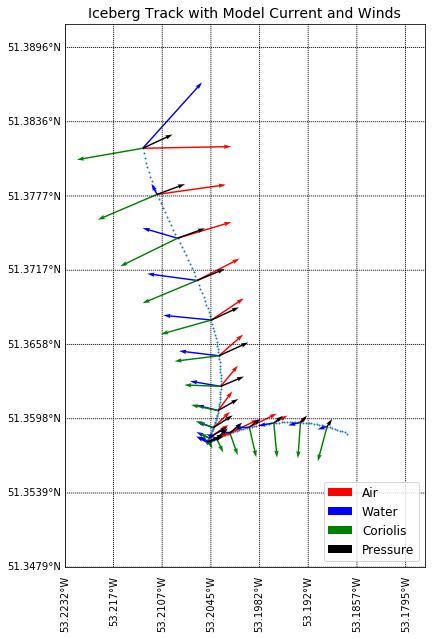

In [20]:
title = 'Iceberg Track with Model Current and Winds'

arrow_colors = ['red', 'blue', 'green', 'black']
arrow_labels = ['Air', 'Water', 'Coriolis', 'Pressure']

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

arrow_scale = 5e5
autoscale_figure = False
pads = [0.01] * 4 
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads}


fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## No Current, Constant Wind

In [21]:
label = 'no_current_constant_wind'
sim.start_velocity = 0, 0
sim.set_constant_currents((0, 0))
sim.set_constant_winds((10, 0))
xds = sim.run_simulation(store_results_as=label)

In [22]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

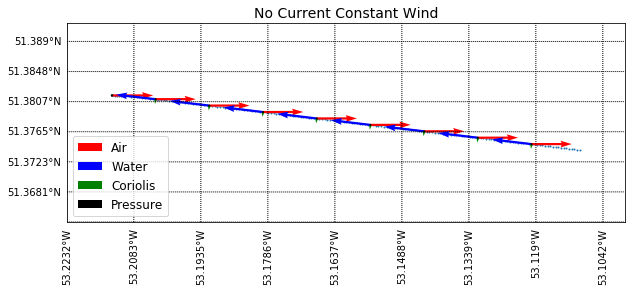

In [23]:
title = 'No Current Constant Wind'

arrow_scale = 1e7
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.01] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## No Wind, Constant Current

In [24]:
label = 'no_wind_constant_current'
sim.start_velocity = 0.1, 0
sim.set_constant_currents((0.1, 0))
sim.set_constant_winds((0, 0))
xds = sim.run_simulation(store_results_as=label)

In [25]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

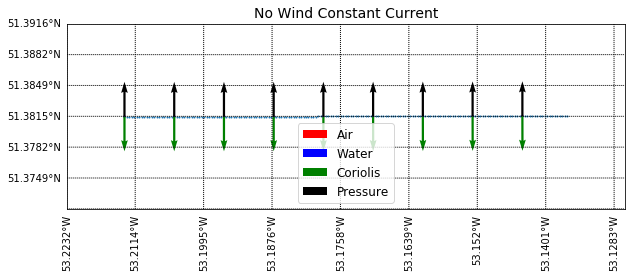

In [26]:
title = 'No Wind Constant Current'

arrow_scale = 1e6
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.01] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## No Wind or Current

In [39]:
label = 'no_wind_or_current'
sim.start_velocity = tc.start_velocity
sim.set_constant_currents((0, 0))
sim.set_constant_winds((0, 0))
xds = sim.run_simulation(store_results_as=label)

In [40]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

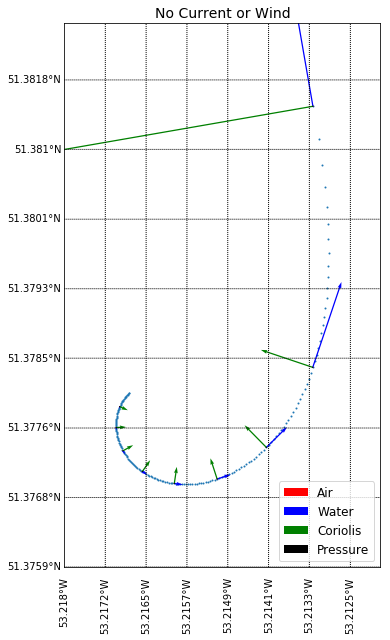

In [41]:
title = 'No Current or Wind'

arrow_scale = 1e5
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.001] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## Constant Current and Wind

In [42]:
label = 'constant_current_and_wind'
sim.start_velocity = 0, 0
sim.set_constant_currents((0.1, 0))
sim.set_constant_winds((10, 0))
xds = sim.run_simulation(store_results_as=label)

In [43]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

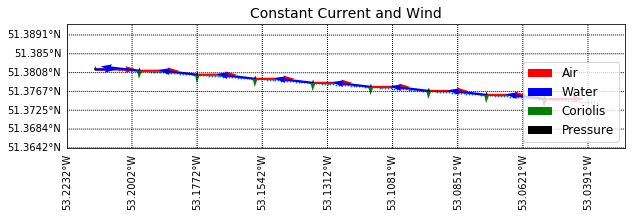

In [44]:
title = 'Constant Current and Wind'

arrow_scale = 1e7
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.01] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

# Varying Berg Size

In [33]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [34]:
sizes = ['SM', 'MED', 'LG', 'VLG']
labels = ['SM', 'MED', 'LG', 'VLG']

for size, label in zip(sizes, labels):

    sim.iceberg_size = size
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)
    

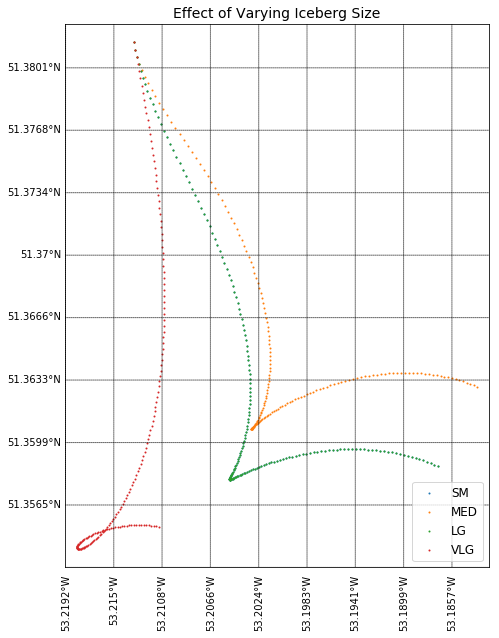

In [35]:
title = 'Effect of Varying Iceberg Size'
pads = [0.001] * 4
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'sizes' + '.png')

# Varying Berg Shape

In [36]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [37]:
shapes = ['TAB', 'NTAB', 'DOM', 'PIN', 'WDG', 'DD', 'BLK']
labels = ['TAB', 'NTAB', 'DOM', 'PIN', 'WDG', 'DD', 'BLK']

for shape, label in zip(shapes, labels):

    sim.iceberg_shape = shape
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)


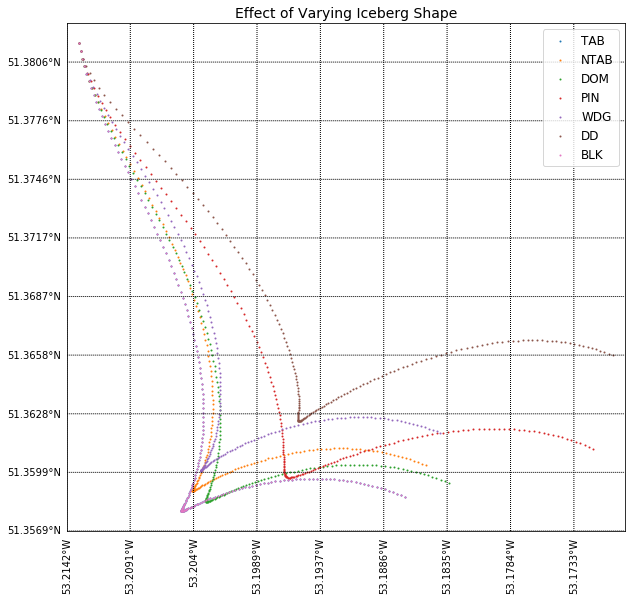

In [38]:
title = 'Effect of Varying Iceberg Shape'
pads = [0.001] * 4
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'shapes' + '.png')

# Effect of changing timestepper

In [45]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [46]:
label = 'euler'
xds = sim.run_simulation(store_results_as=label)

In [48]:
label = 'rk2'
sim.time_stepper = timesteppers.rk2
xds = sim.run_simulation(store_results_as=label)

In [49]:
label = 'rk4'
sim.time_stepper = timesteppers.rk4
xds = sim.run_simulation(store_results_as=label)

In [50]:
label = 'ab2'
sim.time_stepper = timesteppers.ab2
xds = sim.run_simulation(store_results_as=label)

In [52]:
label = 'ab3'
sim.time_stepper = timesteppers.ab3
xds = sim.run_simulation(store_results_as=label)

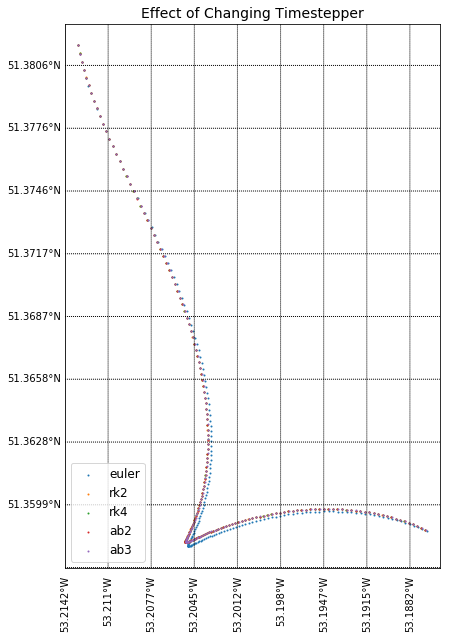

In [55]:
title = 'Effect of Changing Timestepper'
labels = ['euler', 'rk2', 'rk4', 'ab2', 'ab3']
pads = [0.001] * 4
kwargs = {'labels': labels, 'pads': pads, 'title': title}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'timesteppers' + '.png')